In [74]:
from astroquery.sdss import SDSS
from astropy.table import Table
import pandas as pd
import numpy as np
# astronomy things
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle 
import astropy.units as u
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval, LogStretch, LinearStretch, SinhStretch, AsinhStretch

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [58]:
def sigmoid(x):
    """
    uses sigmoid function to scale while perserving distance
    """
    return (1 / (1 + np.e**(-x)))

In [59]:
df = pd.read_csv("data/star_classification.csv")
bands = ['u', 'g', 'r', 'i', 'z']



idx = 88230	 GALAXY


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


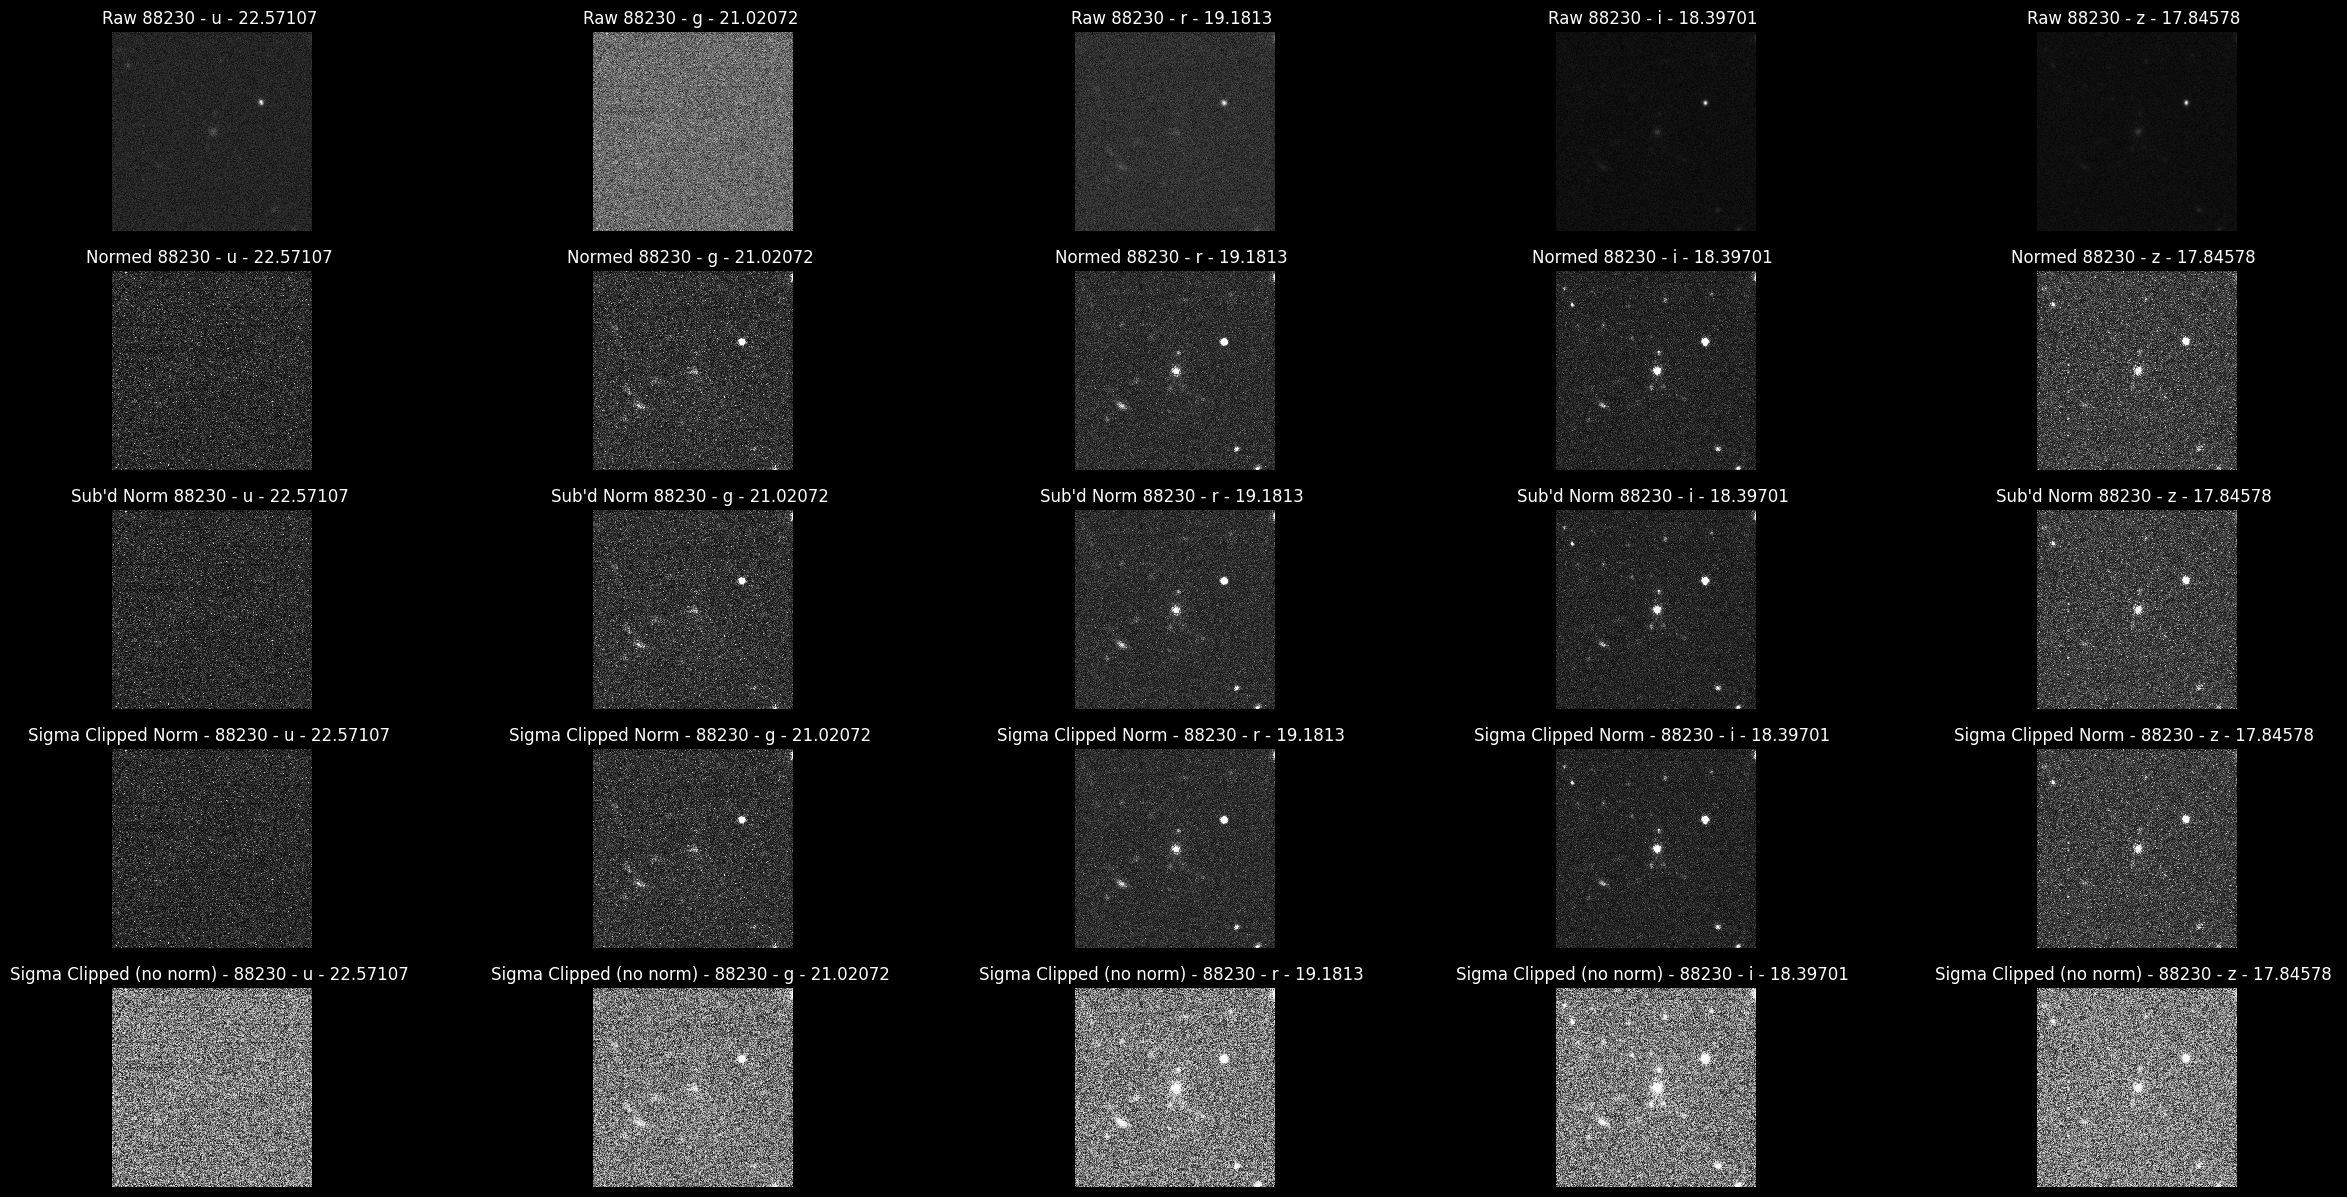

In [84]:
fig,ax = plt.subplots(5,5)
fig.set_size_inches(30,15)


idx = np.random.randint(0,100_000)

# idx = 4
idx = 88230	 	 	
 
object = df.iloc[idx]
print(f"idx = {idx}\t {object['class']}")
run_id = object['run_ID']
rerun_id = object['rerun_ID']
cam_col = object['cam_col']
field_id = object['field_ID']
spec_obj_id = object['spec_obj_ID']

# get coordinates of object RA/DEC
ra = Angle(object['alpha'], unit=u.deg)
dec = Angle(object['delta'], unit=u.deg)
c = SkyCoord(ra, dec, frame='icrs')

xids_table = SDSS.query_region(c) # this can return multiple items
xids = xids_table.to_pandas()
xids = xids.query(f"run == {run_id} and rerun == {rerun_id} and camcol == {cam_col} and field == {field_id}")
xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)
best_plate = xids[xids['distance_from_object'] == xids['distance_from_object'].min()]

best_plate = Table.from_pandas(best_plate.drop("distance_from_object", axis=1))

# LOOP OVER ALL IMAGES HERE
for idx, band in enumerate(bands):
    img = SDSS.get_images(matches=best_plate, band=band)
    header = img[0][0].header
    wcs = WCS(header)
    obj_pix_x, obj_pix_y = wcs.world_to_pixel(c)


    # make chips of the object we are interested in
    chip_data = img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]


    # plotting
    ax[0,idx].imshow(chip_data, cmap='gray')
    ax[0,idx].axis('off')
    ax[0,idx].set_title(f"Raw {object.name} - {band} - {object[band]} ")





    
    
    
    
    # no noise reduction, no background subtraction
    chip_size = 100
    slice_y_0, slice_y_1 = int(obj_pix_y-chip_size), int(obj_pix_y+chip_size)
    slice_x_0, slice_x_1 = int(obj_pix_x-chip_size), int(obj_pix_x+chip_size)

    img_data = img[0][0].data.copy()


    # make chips of the object we are interested in
    chip_data = img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[1,idx].imshow(chip_data, cmap='gray', norm=norm)
    ax[1,idx].axis('off')
    ax[1,idx].set_title(f"Normed {object.name} - {band} - {object[band]} ")

    
    
    
    
    
    # try with noise and background subtraction
    noise = np.std(img_data)
    background = np.median(img_data)
    cleaned_img_data = (img_data - background) / noise

    # chips
    chip_data = cleaned_img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[2,idx].imshow(chip_data, cmap='gray', norm=norm)
    ax[2,idx].axis('off')
    ax[2,idx].set_title(f"Sub'd Norm {object.name} - {band} - {object[band]} ")
    
    
    
    
    
    
    # sigma clipped stats
    mean, median, std = sigma_clipped_stats(img_data)
    sigma_cleaned_img_data = (img_data - median) / std
    
    # chips
    chip_data = sigma_cleaned_img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[3,idx].imshow(chip_data, cmap='gray', norm=norm)
    ax[3,idx].axis('off')
    ax[3,idx].set_title(f"Sigma Clipped Norm - {object.name} - {band} - {object[band]} ")
    
    
    
    
    
    
    # with sigmoid now?
    chip_data = sigmoid(chip_data)

    # plotting
    ax[4,idx].imshow(chip_data, cmap='gray')
    ax[4,idx].axis('off')
    ax[4,idx].set_title(f"Sigma Clipped (no norm) - {object.name} - {band} - {object[band]} ")
    


